In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

DATASET_DIR = '../../datasets/'

import os
for dirname, _, filenames in os.walk(DATASET_DIR+'bbc-news'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../../datasets/bbc-news/BBC News Train.csv
../../datasets/bbc-news/.DS_Store
../../datasets/bbc-news/BBC News Test.csv
../../datasets/bbc-news/BBC News Sample Solution.csv


In [6]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.3 MB/s eta 0:00:00a 0:00:01


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [9]:
dataset = pd.read_csv(DATASET_DIR+'bbc-news/BBC News Train.csv')
test_set = pd.read_csv(DATASET_DIR+'bbc-news/BBC News Test.csv')

In [10]:
dataset.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [11]:
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [12]:
dataset['categoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,categoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [13]:
category = dataset[["Category","categoryId"]].drop_duplicates().sort_values('categoryId')
category

,Category,categoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [14]:
dataset.groupby('Category').categoryId.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: categoryId, dtype: int64

# Data Visualization

<Axes: xlabel='Category'>

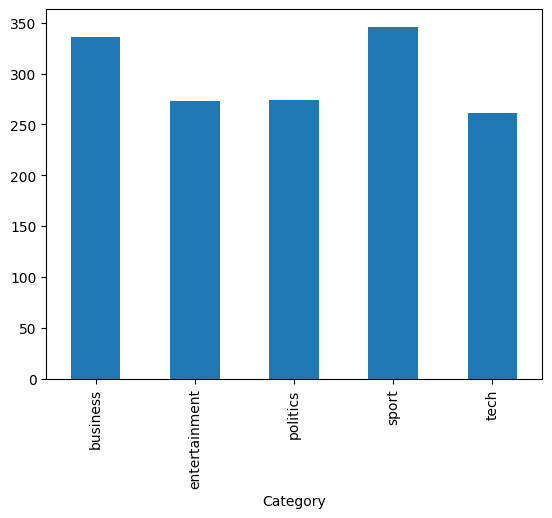

In [15]:
dataset.groupby('Category').categoryId.count().plot.bar(ylim=0)

In [16]:
text = dataset["Text"] 
text.head()

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
Name: Text, dtype: object

In [17]:
category = dataset["Category"]
category.head()

0    business
1    business
2    business
3        tech
4    business
Name: Category, dtype: object

# Data Preprocessing

In [24]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

def preprocessDataset(train_text):
    # Ensure input is string
    train_text = str(train_text)
    
    # Word tokenization using NLTK's word_tokenize
    tokenized_train_set = word_tokenize(train_text.lower())
    
    # Stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if i not in stop_words]
    
    # Join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
    
    # Remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
    
    # Stemming using NLTK's PorterStemmer
    stemmer = PorterStemmer()
    stem_input = word_tokenize(numberremove_text)
    stem_text = ' '.join([stemmer.stem(word) for word in stem_input])
    
    # Lemmatization using NLTK's WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    lem_input = word_tokenize(stem_text)
    lem_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
    
    return lem_text


In [25]:
print("dataset:", type(dataset))

dataset: <class 'pandas.core.frame.DataFrame'>


In [26]:
dataset['Text'] = dataset['Text'].apply(preprocessDataset)
text = dataset['Text']
category = dataset['Category']
text.head()

0    worldcom ex-boss launch defenc lawyer defend f...
1    german busi confid slide german busi confid fe...
2    bbc poll indic econom gloom citizen major nati...
3    lifestyl govern mobil choic faster well funkie...
4    enron bos $ m payout eighteen former enron dir...
Name: Text, dtype: object

In [36]:
category.head()

0    business
1    business
2    business
3        tech
4    business
Name: Category, dtype: object

# Split train set

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(text,category, test_size = 0.3, random_state = 60,shuffle=True, stratify=category)

print("X_train:", type(X_train), X_train.shape)
print("X_test:", type(X_test), X_test.shape)

print("Y_train:", type(Y_train), Y_train.shape)
print("Y_test:", type(Y_test), Y_test.shape)

X_train: <class 'pandas.core.series.Series'> (1043,)
X_test: <class 'pandas.core.series.Series'> (447,)
Y_train: <class 'pandas.core.series.Series'> (1043,)
Y_test: <class 'pandas.core.series.Series'> (447,)


# Multinomial Naive Bayes

In [28]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train,Y_train)

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))


Naive Bayes Train Accuracy Score : 99% 
Naive Bayes Test Accuracy Score  : 96% 

               precision    recall  f1-score   support

     business       0.98      0.94      0.96       105
         tech       0.93      1.00      0.96        76
     politics       0.93      0.94      0.93        81
        sport       1.00      0.98      0.99       106
entertainment       0.96      0.95      0.96        79

     accuracy                           0.96       447
    macro avg       0.96      0.96      0.96       447
 weighted avg       0.96      0.96      0.96       447



# Decision Tree

In [29]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(X_train, Y_train)

test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 80% 

               precision    recall  f1-score   support

     business       0.81      0.75      0.78       109
         tech       0.72      0.87      0.79        68
     politics       0.77      0.80      0.78        79
        sport       0.91      0.83      0.87       114
entertainment       0.76      0.77      0.76        77

     accuracy                           0.80       447
    macro avg       0.79      0.80      0.80       447
 weighted avg       0.81      0.80      0.80       447



# Random Forest Classifier

In [30]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ])

rfc.fit(X_train, Y_train)

test_predict = rfc.predict(X_test)

train_accuracy = round(rfc.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("K-Nearest Neighbour Train Accuracy Score : {}% ".format(train_accuracy ))
print("K-Nearest Neighbour Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

K-Nearest Neighbour Train Accuracy Score : 100% 
K-Nearest Neighbour Test Accuracy Score  : 95% 

               precision    recall  f1-score   support

     business       0.97      0.92      0.94       107
         tech       0.91      1.00      0.96        75
     politics       0.89      0.95      0.92        77
        sport       1.00      0.95      0.97       110
entertainment       0.95      0.95      0.95        78

     accuracy                           0.95       447
    macro avg       0.94      0.95      0.95       447
 weighted avg       0.95      0.95      0.95       447



# Test Set

In [31]:
test_set.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


# Train with Naive Bayes

In [32]:
test_set['Text'] = test_set['Text'].apply(preprocessDataset)

test_id = test_set['ArticleId']
test_text = test_set['Text']
y_prdict = nb.predict(test_text)

In [33]:
#submission = pd.DataFrame(test_id)
submission = pd.DataFrame(list(zip(test_id, y_prdict)),
               columns =['ArticleId', 'Category'])
submission.head(20)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


In [21]:
submission.to_csv('submission.csv', index=False)